In [69]:
import  numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.express as px
import plotly.graph_objects as go

from pycountry_convert import country_name_to_country_alpha3, country_alpha2_to_country_name

from sklearn.preprocessing import OneHotEncoder
from scipy.stats import f_oneway, f
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 100)

In [7]:
pd.set_option('display.max_rows', 100)
data = pd.read_csv('/content/human_trafficking.csv', low_memory=False)

data.replace('-99', np.nan, inplace=True)
data.replace(-99, np.nan, inplace=True)
data = data[~data.ageBroad.isna() & ~data.citizenship.isna() & ~data.CountryOfExploitation.isna()]
data.drop(columns=['majorityStatusAtExploit', 'majorityEntry'], inplace=True)
data.replace(np.nan, 0, inplace=True)
data['RecruiterRelationship'].replace(0, np.nan, inplace=True)
data['typeOfExploitConcatenated'].replace(0, np.nan, inplace=True)
data.isna().sum() / len(data.index)

yearOfRegistration                        0.000000
Datasource                                0.000000
gender                                    0.000000
ageBroad                                  0.000000
majorityStatus                            0.000000
citizenship                               0.000000
meansOfControlDebtBondage                 0.000000
meansOfControlTakesEarnings               0.000000
meansOfControlRestrictsFinancialAccess    0.000000
meansOfControlThreats                     0.000000
meansOfControlPsychologicalAbuse          0.000000
meansOfControlPhysicalAbuse               0.000000
meansOfControlSexualAbuse                 0.000000
meansOfControlFalsePromises               0.000000
meansOfControlPsychoactiveSubstances      0.000000
meansOfControlRestrictsMovement           0.000000
meansOfControlRestrictsMedicalCare        0.000000
meansOfControlExcessiveWorkingHours       0.000000
meansOfControlUsesChildren                0.000000
meansOfControlThreatOfLawEnforc

In [8]:
def get_alpha3(col):
    try:
        iso_3 =  country_name_to_country_alpha3(col)
    except:
        iso_3 = 'Unknown'
    return iso_3

def get_name(col):
    try:
        name =  country_alpha2_to_country_name(col)
    except:
        name = 'Unknown'
    return name

In [9]:
data['countryCitizenship'] = data['citizenship'].apply(lambda x: get_name(x))
data['alpha3Citizenship'] = data['countryCitizenship'].apply(lambda x: get_alpha3(x))

data['CountryOfExploitation'] = data['CountryOfExploitation'].apply(lambda x: get_name(x))
data['alpha3CountryOfExploitation'] = data['CountryOfExploitation'].apply(lambda x: get_alpha3(x))
data['age'] = data['ageBroad'].str.extract('(\d+)')

In [54]:
origin = pd.get_dummies(data['alpha3Citizenship'], prefix='origin')
destination = pd.get_dummies(data['alpha3CountryOfExploitation'], prefix='destination')
gender = pd.get_dummies(data['gender'], prefix='sex')

df = pd.concat((data, origin, destination), axis=1)

cols = df.columns
cols = [c for c in cols if 'origin' in c or 'destination' in c]
#cols += ['age']
cols
df = df[cols]
df

,origin_AFG,origin_ALB,origin_BFA,origin_BGD,origin_BGR,origin_BLR,origin_BOL,origin_CHN,origin_CIV,origin_COD,origin_COL,origin_ERI,origin_GHA,origin_GIN,origin_GNB,origin_HTI,origin_IDN,origin_KAZ,origin_KEN,origin_KGZ,origin_KHM,origin_KOR,origin_LAO,origin_LKA,origin_MDA,origin_MDG,origin_MEX,origin_MLI,origin_MMR,origin_NER,origin_NGA,origin_NPL,origin_PHL,origin_ROU,origin_SEN,origin_SLE,origin_THA,origin_TJK,origin_TKM,origin_UGA,...,destination_GHA,destination_HKG,destination_HTI,destination_IDN,destination_ITA,destination_JOR,destination_KAZ,destination_KHM,destination_LBN,destination_LBY,destination_MDA,destination_MDG,destination_MKD,destination_MUS,destination_MYS,destination_OMN,destination_PHL,destination_POL,destination_QAT,destination_ROU,destination_RUS,destination_SAU,destination_SEN,destination_SGP,destination_SLE,destination_SRB,destination_SYR,destination_THA,destination_TJK,destination_TKM,destination_TTO,destination_TUR,destination_TWN,destination_UGA,destination_UKR,destination_USA,destination_UZB,destination_Unknown,destination_VNM,destination_ZAF
104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48782,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
48783,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
48784,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
48785,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


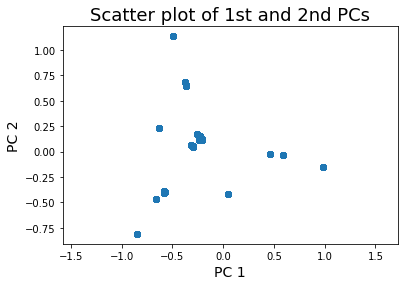

In [55]:
from sklearn.decomposition import PCA
pca = PCA() # Initialize with n_components parameter to only find the top eigenvectors
z = pca.fit_transform(df)

plt.scatter(z[:,0],z[:,1])
plt.title("Scatter plot of 1st and 2nd PCs",size=18)
plt.xlabel("PC 1",size=14)
plt.ylabel("PC 2",size=14)
plt.axis("equal")
plt.show()

In [ ]:
from sklearn.manifold import MDS

mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(df)
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1],)
plt.title("MDS Plot",size=18)
plt.axis("equal")
plt.show()

In [46]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,verbose=1,perplexity=50)
z_tsne50 = tsne.fit_transform(df)
plt.scatter(z_tsne50[:,0],z_tsne50[:,1],c=df.y)
plt.title("TSNE, perplexity 31",size=18)
plt.axis("equal")
plt.show()

ValueError: ignored

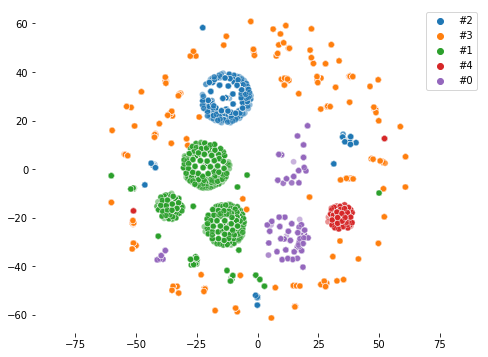

In [60]:
fig = plt.figure(figsize=(8,6))
ax = sns.scatterplot(z_tsne30[:,0],z_tsne30[:,1], hue=df.y, alpha=0.5)
ax.legend()
sns.despine(bottom = True, left = True)
plt.axis("equal")
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


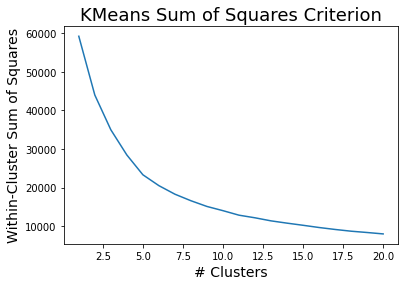

In [56]:
from sklearn.cluster import KMeans
all_kmeans = [KMeans(n_clusters=i+1,n_init=100) for i in range(20)]
# i-th kmeans fits i+1 clusters
for i in range(20):
    print(i)
    all_kmeans[i].fit(df)

inertias = [all_kmeans[i].inertia_ for i in range(20)]
plt.plot(np.arange(1,21),inertias)
plt.title("KMeans Sum of Squares Criterion",size=18)
plt.xlabel("# Clusters",size=14)
plt.ylabel("Within-Cluster Sum of Squares",size=14)
plt.show()

In [57]:
kmeans = KMeans(n_clusters=5,n_init=10)
y = kmeans.fit_predict(df)

In [58]:
df['y'] = y
df['y'] = '#' + df['y'].astype(str)
df

,origin_AFG,origin_ALB,origin_BFA,origin_BGD,origin_BGR,origin_BLR,origin_BOL,origin_CHN,origin_CIV,origin_COD,origin_COL,origin_ERI,origin_GHA,origin_GIN,origin_GNB,origin_HTI,origin_IDN,origin_KAZ,origin_KEN,origin_KGZ,origin_KHM,origin_KOR,origin_LAO,origin_LKA,origin_MDA,origin_MDG,origin_MEX,origin_MLI,origin_MMR,origin_NER,origin_NGA,origin_NPL,origin_PHL,origin_ROU,origin_SEN,origin_SLE,origin_THA,origin_TJK,origin_TKM,origin_UGA,...,destination_HKG,destination_HTI,destination_IDN,destination_ITA,destination_JOR,destination_KAZ,destination_KHM,destination_LBN,destination_LBY,destination_MDA,destination_MDG,destination_MKD,destination_MUS,destination_MYS,destination_OMN,destination_PHL,destination_POL,destination_QAT,destination_ROU,destination_RUS,destination_SAU,destination_SEN,destination_SGP,destination_SLE,destination_SRB,destination_SYR,destination_THA,destination_TJK,destination_TKM,destination_TTO,destination_TUR,destination_TWN,destination_UGA,destination_UKR,destination_USA,destination_UZB,destination_Unknown,destination_VNM,destination_ZAF,y
104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,#2
105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,#2
106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,#2
107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,#2
108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,#2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48782,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,#3
48783,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,#3
48784,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,#3
48785,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,#3


In [61]:
dff = df.groupby('y').mean().T

In [75]:
dff['#1'].sort_values(ascending=False).head(50)

origin_UKR         0.995376
destination_UKR    0.685204
destination_RUS    0.215258
destination_POL    0.040329
destination_TUR    0.022348
destination_ARE    0.012844
destination_MKD    0.006936
destination_CZE    0.004881
origin_Unknown     0.004624
destination_SRB    0.003468
destination_AUT    0.003082
destination_KAZ    0.002183
destination_BGR    0.001798
destination_BIH    0.001670
origin_NPL         0.000000
origin_MLI         0.000000
origin_MMR         0.000000
origin_NER         0.000000
origin_NGA         0.000000
origin_MEX         0.000000
destination_ZAF    0.000000
origin_PHL         0.000000
origin_ROU         0.000000
origin_SEN         0.000000
origin_MDG         0.000000
origin_THA         0.000000
origin_TJK         0.000000
origin_TKM         0.000000
origin_UGA         0.000000
origin_USA         0.000000
origin_SLE         0.000000
origin_KOR         0.000000
origin_MDA         0.000000
origin_LKA         0.000000
origin_ALB         0.000000
origin_BFA         0